In [1]:
import numpy as np
import pandas as pd

otu_df = pd.read_csv('/home/esp/data_analyze/15.03.2024/data/init_data/Res1/OTU.txt', sep='\t')
hiera_blast = pd.read_csv('/home/esp/data_analyze/15.03.2024/data/init_data/Res1/hiera_BLAST.txt', sep='\t')
meta_map_init = pd.read_csv('/home/esp/data_analyze/15.03.2024/data/init_data/Res1/primary/in.map', sep='\t')
meta = pd.read_csv('/home/esp/data_analyze/15.03.2024/data/init_data/Res1/metadata_geo.csv',  sep='\t')
genus_df = pd.read_csv('/home/esp/data_analyze/15.03.2024/data/init_data/Res1/higherLvl/Genus.txt', sep='\t')

In [2]:
meta_map_df = meta_map_init.copy()
meta_map_df = meta_map_df.drop(columns=['SequencingRun'])
for column in meta_map_df.select_dtypes(include=['object']):  
    meta_map_df[column] = meta_map_df[column].str.replace('.extendedFrags.fastq.gz', '', regex=False)

meta_map_df['fastqFile'] = meta_map_df['fastqFile'].apply(lambda x: x.split('_')[0])
meta_map_df = meta_map_df.rename(columns={'fastqFile':'ID'})
meta_map_df['ID'] = pd.to_numeric(meta_map_df['ID'], errors='coerce')

merged_df = pd.merge(meta_map_df, meta, on='ID')

final_meta_df = merged_df[['#SampleID', 'ID','GROUP']]
final_meta_df.head()

,#SampleID,ID,GROUP
0,SMPL100,12161.0,2
1,SMPL101,12162.0,2
2,SMPL102,12164.0,2
3,SMPL103,12172.0,2
4,SMPL104,12180.0,2


In [5]:
import pandas as pd

genus_df_transposed = genus_df.T.reset_index()

genus_df_transposed.columns = ['#SampleID'] + list(genus_df['Genus'])

genus_df_transposed = genus_df_transposed.drop(genus_df_transposed.index[0])

merged_genus_df = pd.merge(final_meta_df, genus_df_transposed, on='#SampleID', how='left')
merged_genus_df = merged_genus_df.drop(columns=['ID'])
replace_dict = {
    1: "AstNIS",
    2: "AstReg",
    3: "KokNis",
    4: "KokReg",
    5: "SemNis",
    6: "SemReg",
    7: "UstNis",
    8: "UstReg",
    9: "KarNis",
    10: "KarReg"
}

merged_genus_df['GROUP'] = merged_genus_df['GROUP'].replace(replace_dict)

merged_genus_df.head()

,#SampleID,GROUP,Bacteria;?;?;?;?;?,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;?;?,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Actinomycetaceae;Actinomyces,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Corynebacteriaceae;Corynebacterium,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Micrococcaceae;Micrococcus,Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Propionibacteriaceae;?,Bacteria;Actinobacteriota;?;?;?;?,Bacteria;Actinobacteriota;Acidimicrobiia;Microtrichales;?;?,...,Bacteria;TM7;TM7-3;I025;Rs-045;[Saccharibacteria],Bacteria;Tenericutes;Mollicutes;Mycoplasmatales;Mycoplasmataceae;Mycoplasma,Bacteria;Verrucomicrobiota;Lentisphaeria;Victivallales;Victivallaceae;Victivallis,Bacteria;Verrucomicrobiota;Lentisphaeria;Victivallales;vadinBE97;uncultured rumen bacterium,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia,Bacteria;WPS-2;?;?;?;?,Eukaryota;Ascomycota;Saccharomycetes;Saccharomycetales;Debaryomycetaceae;Candida-Lodderomyces clade,Eukaryota;Phragmoplastophyta;Embryophyta;?;?;?,Eukaryota;Vertebrata;Mammalia;?;?;?,noHit;
0,SMPL100,AstReg,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599
1,SMPL101,AstReg,135,0,35,0,0,0,540,0,...,0,0,0,0,0,0,0,0,0,3226
2,SMPL102,AstReg,726,0,1,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,3783
3,SMPL103,AstReg,1,0,3,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,1871
4,SMPL104,AstReg,2,0,4,0,0,0,121,0,...,0,0,0,0,0,0,0,0,0,337


In [22]:
import pandas as pd

long_format_df = pd.melt(merged_genus_df, 
                         id_vars=['#SampleID', 'GROUP'], 
                         var_name='Taxonomy', 
                         value_name='Value')

long_format_df['OTU'] = 'ASV' + (long_format_df.index + 1).astype(str).str.zfill(4)
long_format_df = long_format_df[['OTU', 'Taxonomy', '#SampleID', 'GROUP', 'Value']]

long_format_df.head()

,OTU,Taxonomy,#SampleID,GROUP,Value
0,ASV0001,Bacteria;?;?;?;?;?,SMPL100,AstReg,2
1,ASV0002,Bacteria;?;?;?;?;?,SMPL101,AstReg,135
2,ASV0003,Bacteria;?;?;?;?;?,SMPL102,AstReg,726
3,ASV0004,Bacteria;?;?;?;?;?,SMPL103,AstReg,1
4,ASV0005,Bacteria;?;?;?;?;?,SMPL104,AstReg,2


In [88]:
def transform_taxonomy(row):
    tax_levels = row.split(';')
    prefixes = ['k_', 'p_', 'c_', 'o_', 'f_', 'g_', 's_']
    transformed = '|'.join([f"{prefix}{level}" for prefix, level in zip(prefixes, tax_levels)])
    return transformed

new_long_format_df = long_format_df.copy()

new_long_format_df['Taxonomy'] = new_long_format_df['Taxonomy'].apply(transform_taxonomy)
new_long_format_df['Taxonomy'] = new_long_format_df['Taxonomy'].replace(r'k_noHit\|p_', 'noHit', regex=True)
#new_long_format_df.to_csv('def2.csv', sep='\t')

def trim_taxonomy(taxonomy):
    pos = taxonomy.find('_?')
    if pos != -1:
        return taxonomy[:taxonomy.rfind('|', 0, pos)]
    else:
        return taxonomy

new_long_format_df['Taxonomy'] = new_long_format_df['Taxonomy'].apply(trim_taxonomy)
for_lefse = new_long_format_df.copy()

new_long_format_df['Taxonomy'] = new_long_format_df['Taxonomy'].str.split('|').str[-1]
#new_long_format_df.to_csv('def.csv', sep='\t')

new_long_format_df_noHit = new_long_format_df[new_long_format_df['Taxonomy'] != 'noHit']

new_long_format_df.head()

,OTU,Taxonomy,#SampleID,GROUP,Value
0,ASV0001,k_Bacteria,SMPL100,AstReg,2
1,ASV0002,k_Bacteria,SMPL101,AstReg,135
2,ASV0003,k_Bacteria,SMPL102,AstReg,726
3,ASV0004,k_Bacteria,SMPL103,AstReg,1
4,ASV0005,k_Bacteria,SMPL104,AstReg,2


In [33]:
def rel_abundance(new_long_format_df):
    taxon_abundance = new_long_format_df.groupby(['#SampleID', 'Taxonomy', 'GROUP'])['Value'].sum().reset_index()
    total_abundance = taxon_abundance.groupby(['#SampleID', 'GROUP'])['Value'].sum().reset_index().rename(columns={'Value': 'Total'})
    taxon_abundance = taxon_abundance.merge(total_abundance, on=['#SampleID', 'GROUP'])
    
    # Проверка, чтобы избежать деления на ноль
    taxon_abundance['RelativeAbundance'] = taxon_abundance.apply(lambda row: row['Value'] / row['Total'] if row['Total'] > 0 else 0, axis=1)
    
    return taxon_abundance

taxon_abundance_with_hit = rel_abundance(new_long_format_df)
taxon_abundance_no_hit = rel_abundance(new_long_format_df_noHit)

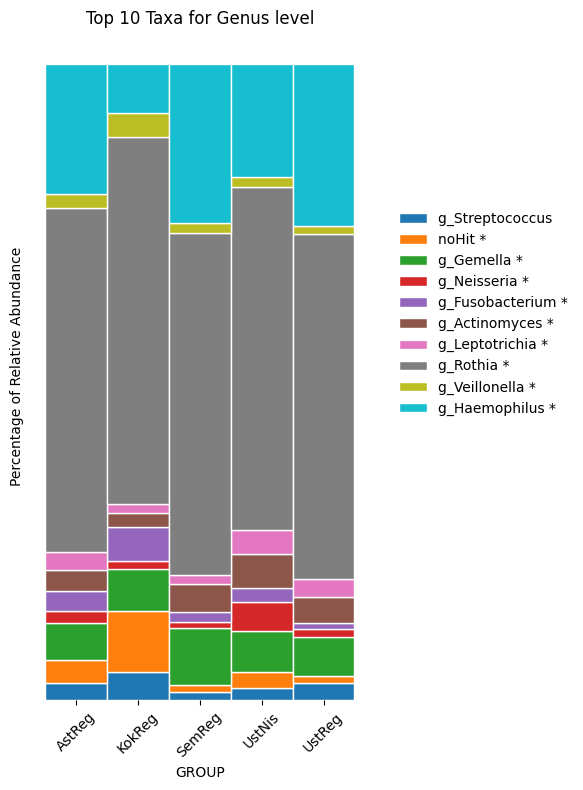

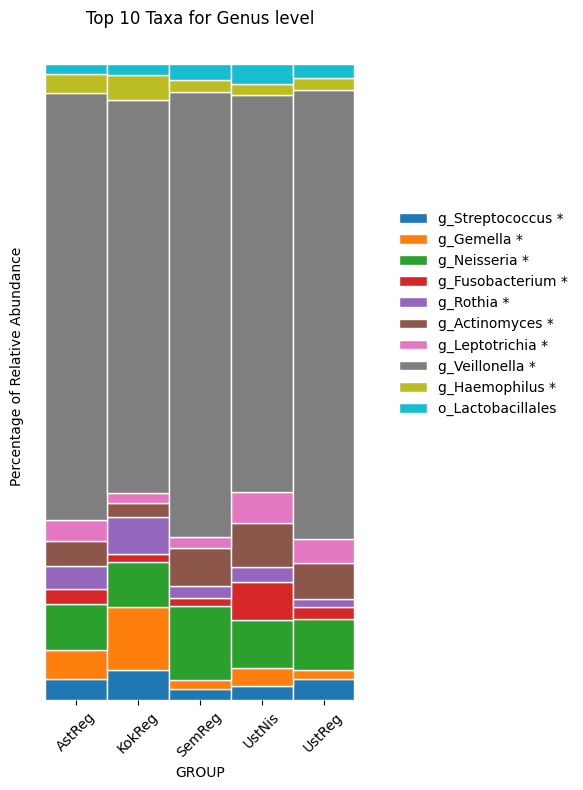

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

def stack_plot(taxon_abundance, __name=''):
    # Предварительная обработка и расчет среднего относительного изобилия
    mean_abundance = taxon_abundance.groupby(['GROUP', 'Taxonomy'])['RelativeAbundance'].mean().reset_index()
    mean_abundance['RelativeAbundance'] = pd.to_numeric(mean_abundance['RelativeAbundance'], errors='coerce')
    
    # Выборка топ-10 таксонов
    top_taxa = mean_abundance.groupby('Taxonomy')['RelativeAbundance'].mean().nlargest(10).index
    top_taxon_abundance = mean_abundance[mean_abundance['Taxonomy'].isin(top_taxa)]

    # Расчет p-значений для каждого таксона с помощью ANOVA
    p_values = {}
    for taxon in top_taxa:
        groups = taxon_abundance[taxon_abundance['Taxonomy'] == taxon].groupby('GROUP')['RelativeAbundance'].apply(list)
        p_value = f_oneway(*groups).pvalue
        p_values[taxon] = p_value

    file = 'data/output_data/relative_abundance/pvalues.csv'
    with open(file, 'w',) as uniq_data_file:
        uniq_data_file.write(f"\n{p_values}")

    # Форматирование легенды с учетом p-значений
    legend_labels = [f"{taxon} {'*' * (1 if p < 0.05 else 2 if p < 0.01 else 3 if p < 0.001 else 0)}" for taxon, p in p_values.items()]

    # Создание сводной таблицы и ее нормализация
    pivot_table = top_taxon_abundance.pivot_table(index='GROUP', columns='Taxonomy', values='RelativeAbundance', aggfunc='mean')
    pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Визуализация
    colors = sns.color_palette('tab10', n_colors=len(top_taxa))
    fig, ax = plt.subplots(figsize=(6, 8))
    pivot_table.plot(kind='bar', stacked=True, color=colors, width=1, edgecolor='white', ax=ax)
    ax.set_title('Top 10 Taxa for Genus level')
    ax.set_ylabel('Percentage of Relative Abundance')
    ax.set_facecolor('none')
    fig.set_facecolor('none')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.legend(legend_labels, title="", bbox_to_anchor=(1.05, 0.75), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.savefig(f'data/output_data/relative_abundance/stack{__name}.pdf', bbox_inches = 'tight')
    plt.show()

stack_plot(taxon_abundance_with_hit, ' noHit')
stack_plot(taxon_abundance_no_hit, ' without noHit')



/tmp/ipykernel_31763/221266115.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RelativeAbundance', y='Taxonomy', data=top_dominant_taxa, palette='Spectral', width=1)
/tmp/ipykernel_31763/221266115.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RelativeAbundance', y='Taxonomy', data=top_dominant_taxa, palette='Spectral', width=1)


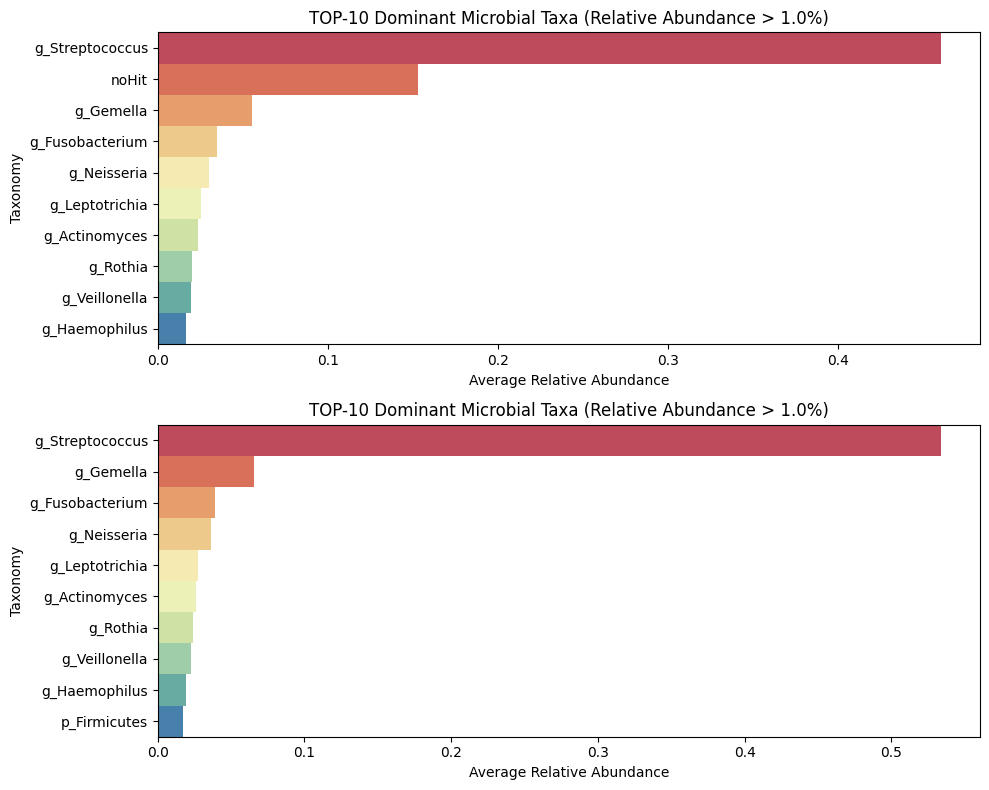

In [57]:
def barplot_relative_abundance(dataframes):
    plt.figure(figsize=(10, 8))  
    for i in range(len(dataframes)):
        df = dataframes[i]
        mean_relative_abundance = df.groupby('Taxonomy')['RelativeAbundance'].mean().reset_index()

        threshold = 0.01  
        dominant_taxa = mean_relative_abundance[mean_relative_abundance['RelativeAbundance'] > threshold]

        top_n = 10
        top_dominant_taxa = dominant_taxa.sort_values(by='RelativeAbundance', ascending=False).head(top_n)

        plt.subplot(len(dataframes), 1, i+1) 
        sns.barplot(x='RelativeAbundance', y='Taxonomy', data=top_dominant_taxa, palette='Spectral', width=1)
        plt.title(f'TOP-{top_n} Dominant Microbial Taxa (Relative Abundance > {threshold*100}%)')
        plt.xlabel('Average Relative Abundance')
        plt.ylabel('Taxonomy')

    plt.tight_layout()  
    plt.savefig('data/output_data/relative_abundance/top_10_general.pdf')
    plt.show()  

dataframes = [taxon_abundance_with_hit, taxon_abundance_no_hit] 
barplot_relative_abundance(dataframes)


In [89]:
for_lefse.head()

,OTU,Taxonomy,#SampleID,GROUP,Value
0,ASV0001,k_Bacteria,SMPL100,AstReg,2
1,ASV0002,k_Bacteria,SMPL101,AstReg,135
2,ASV0003,k_Bacteria,SMPL102,AstReg,726
3,ASV0004,k_Bacteria,SMPL103,AstReg,1
4,ASV0005,k_Bacteria,SMPL104,AstReg,2


In [98]:
pivot_table_lefse = for_lefse.pivot_table(index='Taxonomy', columns=['GROUP', '#SampleID'], values='Value', aggfunc='sum').fillna(0)
# pivot_table_lefse.to_csv('data/output_data/lefse/for_lefse.tsv', sep='\t')
pivot_table_lefse.head()

/tmp/ipykernel_31763/3838056858.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_table_lefse = for_lefse.pivot_table(index='Taxonomy', columns=['GROUP', '#SampleID'], values='Value', aggfunc='sum').fillna(0)


GROUP                                               AstReg                  \
#SampleID                                          SMPL100 SMPL101 SMPL102   
Taxonomy                                                                     
k_Bacteria                                               2     135     726   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0      35       1   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   

GROUP                                                                       \
#SampleID                                          SMPL103 SMPL104 SMPL105   
Taxonomy                                                                     
k_Bacteria                                               1       2      32   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       3       4      12   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   

GROUP                                                                       \
#SampleID                                          SMPL106 SMPL107 SMPL108   
Taxonomy                                                                     
k_Bacteria                                              30       0       1   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...      96       1       2   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   

GROUP                                                       ...  UstReg  \
#SampleID                                          SMPL109  ... SMPL440   
Taxonomy                                                    ...           
k_Bacteria                                               0  ...      31   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0  ...       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...      15  ...       7   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0  ...       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0  ...       0   

GROUP                                                                       \
#SampleID                                          SMPL441 SMPL442 SMPL443   
Taxonomy                                                                     
k_Bacteria                                               2       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   

GROUP                                                                       \
#SampleID                                          SMPL444 SMPL445 SMPL446   
Taxonomy                                                                     
k_Bacteria                                              11     561       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0     250       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   
k_Bacteria|p_Actinobacteria|c_Actinobacteria|o_...       0       0       0   

GROUP                                                                       
#SampleID                                          SMPL447 SMPL448 SMPL449  
Taxonomy                                                                    
k_Bacteria                                 

In [92]:
is_numeric = pivot_table_lefse.applymap(lambda x: isinstance(x, (int, float)))

all_cells_are_numeric = is_numeric.all().all()

print(all_cells_are_numeric)

True


/tmp/ipykernel_31763/763135316.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  is_numeric = pivot_table_lefse.applymap(lambda x: isinstance(x, (int, float)))
